In [227]:
from coffea.util import load
import datetime
import matplotlib.pyplot as plt
import mplhep as hep
import yaml
import dill
import pandas as pd
plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 100#200 # Change for higher resolution
hep.style.use('CMS')

import numpy as np
#from axo_studies import hist_selection, reco_objects, l1_objects
import utils

In [294]:
config_filename = "config.yaml"
plotting_config_filename = "plotting_config.yaml"
                                            
with open(config_filename, 'r') as stream:
    config = yaml.safe_load(stream)
with open(plotting_config_filename, 'r') as stream:
    plotting_config = yaml.safe_load(stream)
    
dataset = config["dataset_name"]
todays_date = datetime.date.today().strftime('%Y%m%d')

hist_result_filename = f'hist_result_{dataset}_{todaysDate}.pkl'          # file name containing histograms
 # load file with histograms
with open(hist_result_filename, 'rb') as file:
    hist_result = dill.load(file)
#hist_result = load(hist_result_filename)
hist_result

{'2024I_test': {'cutflow': [{'start': 159091},
   {'DST_PFScouting_AXONominal': 109850},
   {'DST_PFScouting_AXOTight': 66645}],
  'hists': {'anomaly_score': Hist(
     StrCategory(['2024I_test'], growth=True, name='dataset', label='Primary dataset'),
     StrCategory(['DST_PFScouting_AXONominal', 'DST_PFScouting_AXOTight'], growth=True, name='trigger', label='Trigger'),
     Regular(100, 0, 4000, name='anomaly_score', label='Anomaly Score'),
     storage=Weight()) # Sum: WeightedSum(value=176495, variance=176495)},
  'trigger': ['DST_PFScouting_AXONominal', 'DST_PFScouting_AXOTight']}}

In [283]:
cutflow = hist_result[dataset]['cutflow']
# Convert list of dictionaries to a single dictionary (merge entries)
cutflow_merged = {k: v for d in cutflow for k, v in d.items()}
# Create a DataFrame with one row
df = pd.DataFrame.from_dict(cutflow_merged,orient="index", columns=["Events"])
df

,Events
start,159091
DST_PFScouting_AXONominal,109850
DST_PFScouting_AXOTight,66645


In [284]:
print("Available histograms:")
for hist in hist_result[dataset]['hists']:
    print("- "+hist)
    
print("\nAvailable triggers:")  
for trigger in hist_result[dataset]['trigger']:
    print("- "+trigger)

Available histograms:
- anomaly_score

Available triggers:
- DST_PFScouting_AXONominal
- DST_PFScouting_AXOTight


In [285]:
hist_result

{'2024I_test': {'cutflow': [{'start': 159091},
   {'DST_PFScouting_AXONominal': 109850},
   {'DST_PFScouting_AXOTight': 66645}],
  'hists': {'anomaly_score': Hist(
     StrCategory(['2024I_test'], growth=True, name='dataset', label='Primary dataset'),
     StrCategory(['DST_PFScouting_AXONominal', 'DST_PFScouting_AXOTight'], growth=True, name='trigger', label='Trigger'),
     Regular(100, 0, 4000, name='anomaly_score', label='Anomaly Score'),
     storage=Weight()) # Sum: WeightedSum(value=176495, variance=176495)},
  'trigger': ['DST_PFScouting_AXONominal', 'DST_PFScouting_AXOTight']}}

In [286]:
hist = hist_result[dataset]['hists']['anomaly_score']#[:]#[:, trigger, obj, hist.rebin(rebin)] 
#hist.values()
hist.integrate("anomaly_score")

Hist(
  StrCategory(['2024I_test'], growth=True, name='dataset', label='Primary dataset'),
  StrCategory(['DST_PFScouting_AXONominal', 'DST_PFScouting_AXOTight'], growth=True, name='trigger', label='Trigger'),
  storage=Weight()) # Sum: WeightedSum(value=176495, variance=176495)

In [287]:
def auto_zoom_x(hist):
    filled = hist.values() > 0
    filled_temp = filled[0][0]
    for i in range(len(filled[0])):
        filled_temp = np.logical_or(filled_temp,filled[0][i])
    
    lowest = np.min(hist.axes.edges[2].flatten()[0:-1][filled_temp])
    highest = np.max(hist.axes.edges[2].flatten()[1:][filled_temp])
    return [lowest, highest]


In [288]:

lowest 

0.0

In [293]:
plotting_config["trigger_labels"]

[{'DST_PFScouting_AXOLoose': 'AXO Loose'},
 {'DST_PFScouting_AXONominal': 'AXO Nominal'},
 {'DST_PFScouting_AXOTight': 'AXO Tight'},
 {'DST_PFScouting_AXOVLoose': ' AXO VLoose'},
 {'DST_PFScouting_AXOVTight': 'AXO VTight'},
 {'DST_PFScouting_CICADALoose': 'CICADA Loose'},
 {'DST_PFScouting_CICADAMedium': 'CICADA Medium'},
 {'DST_PFScouting_CICADATight': ' CICADA Tight'},
 {'DST_PFScouting_CICADAVLoose': 'CICADA VLoose'},
 {'DST_PFScouting_CICADAVTight': 'CICADA VTight'},
 {'DST_PFScouting_DoubleMuon': 'Double Muon'},
 {'DST_PFScouting_JetHT': 'Jet HT'},
 {'DST_PFScouting_ZeroBias': 'Zero Bias'}]

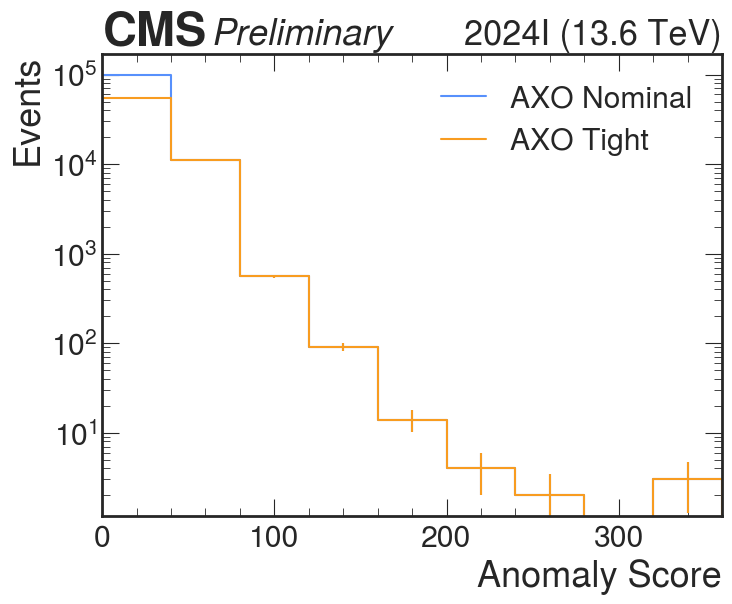

In [295]:

for hist in hist_result[dataset]['hists']:

    fig, ax = plt.subplots(figsize=(8,6))
    for trigger in hist_result[dataset]['trigger']:
        
        utils.draw_hist1d(
                hist_result[dataset]['hists'][hist],
                ax,
                trigger, 
                label=plotting_config["trigger_labels"][trigger], 
                rebin=1, 
                norm=plotting_config["normalized"]
            )


    ax.set_xlim(auto_zoom_x(hist_result[dataset]['hists'][hist]))
        
    if plotting_config["log_scale"]:
        ax.set_yscale('log')
    ax.set_ylabel(f'Events{" [A.U.]" if plotting_config["normalized"] else ""}', loc='top')
    ax.set_xlabel(plotting_config["label_templates"][hist])
    ax.legend(frameon=False)#, fontsize=8)
    hep.cms.label(plotting_config["cms_label"], data=True, lumi=None, year=plotting_config["dataset_titles"][dataset], com=13.6)

    fig.show()
    fig.savefig(f"plots/l1ht_{dataset}_{todaysDate}.pdf", format="pdf")

In [52]:
def make_single_object_plots(objects, obj_labels,
                             plot_config, 
                             purities,
                             hist_result, histpath, 
                             efficiency_trigger_names,
                             dataset_names):
    figs = len(objects)
    # Plot distributions of triggered events 
    fig, ax = plt.subplots(1, figs, figsize=(35, 10))
    for i, obj in enumerate(objects):
        pure_distribution(i,None,
                          obj,
                          obj_labels[obj],
                          ortho_trig,int_trigs,
                          xrange=get_from_list(plot_config[conf]["xranges"],i), 
                          rebin=get_from_list(plot_config[conf]["rebins"],i), 
                          purities=purities,
                          hist_result=hist_result,histpath=histpath,
                          ax=ax,efficiency_trigger_names=efficiency_trigger_names, 
                          dataset_name = dataset_names[dataset_name])

    # Plot fraction of triggered events that are pure
    fig, ax = plt.subplots(1, figs, figsize=(35, 10))
    for i, obj in enumerate(objects):
        axo_pure_efficiency(i,None,
                            obj,
                            obj_labels[obj],
                            ortho_trig,int_trigs,
                            xrange=get_from_list(plot_config[conf]["xranges"],i), 
                            yrange=plot_config[conf]["zooms"],
                            rebin=get_from_list(plot_config[conf]["rebins"],i), 
                            purities=purities,hist_result=hist_result,histpath=histpath,
                            ax=ax,efficiency_trigger_names=efficiency_trigger_names, dataset_name = dataset_names[dataset_name]) 
    return


def make_multi_object_plots(objects, obj_labels,
                             plot_config, 
                             purities,
                             hist_result, histpath, 
                             efficiency_trigger_names,
                             dataset_names):
    figs = len(objects)
    # Plot distributions of triggered events 
    fig, ax = plt.subplots(1, figs, figsize=(35, 10))
    for i, obj in enumerate(objects):
        label = plot_config[conf]["label_template"].format(obj_labels[obj])
        pure_distribution(i,obj,
                          plot_config[conf]["variable_name"],
                          label,
                          ortho_trig,int_trigs,
                          xrange=get_from_list(plot_config[conf]["xranges"],i), 
                          rebin=get_from_list(plot_config[conf]["rebins"],i), 
                          purities=purities,
                          hist_result=hist_result,histpath=histpath,
                          ax=ax,efficiency_trigger_names=efficiency_trigger_names, 
                          dataset_name = dataset_names[dataset_name])

In [ ]:
for histogram in config["histograms_1d"]:
    for reconstruction_level in config["objects"]:
        for objects in config["objects"][reconstruction_level]:
            histograms_1d
    

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
hep.cms.label(cms_label, data=True, lumi=None, year=title, com=13.6)

for trigger in triggers:
    print(trigger)
    hist_current = utils.getHist(hist_result, histpath+['anomaly_score'])
    utils.draw_hist1d(
        hist_current, 
        ax,
        trigger, 
        label=trigger, 
        rebin=1, 
        norm=norm
    )

utils.draw_thresholds(ax, thresholds)

ax.set_xlim([0,100])
ax.set_yscale('log')
ax.set_ylabel(f'Events{" [A.U.]" if norm else ""}', loc='top')
ax.set_xlabel('AXOL1TL Score')
ax.legend(frameon=True, fontsize=8)

fig.show()
fig.savefig(f"plots/anomaly_score_{dataset}_{todaysDate}.pdf", format="pdf")

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_14209/103140625.py:17: SyntaxWarning: invalid escape sequence '\s'
  "label_template": '{} $\sum p_T$ [GeV]',
/tmp/ipykernel_14209/103140625.py:35: SyntaxWarning: invalid escape sequence '\e'
  "label_template": 'All {} $\eta$',


NameError: name 'cms_label' is not defined

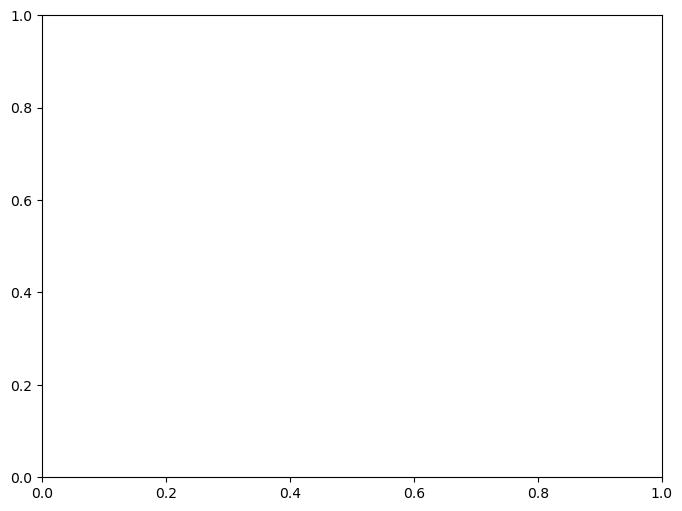